# CNN for Traffic Sign Classification with TensorFlow 2

- [German Traffic Sign Dataset](https://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) from the GTSRB competition
- [Paper](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) on applying CNNs to this problem
- [Helpful link](https://medium.com/analytics-vidhya/solution-to-tensorflow-2-not-using-gpu-119fb3e04daa) for trouble shooting GPU usage in TF 2


# Final Test Accuracy = 96%

## Load train, validation, and test data

In [225]:
# Load pickled data
import pickle
import pandas as pd
import tensorflow as tf

training_file = 'traffic-signs-data/train.p'
validation_file= 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
# separate X and y
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# load mapping from label number to name of label
signnames = pd.read_csv('signnames.csv')

## Exploratory Data Analysis (EDA)

In [2]:
# summary of data
n_train = len(X_train)
n_valid = len(X_valid)
n_test = len(X_test)
img_shape = X_train[0].shape
n_classes = len(signnames)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", img_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


View some signs and their labels. **Note** the variability in lighting!

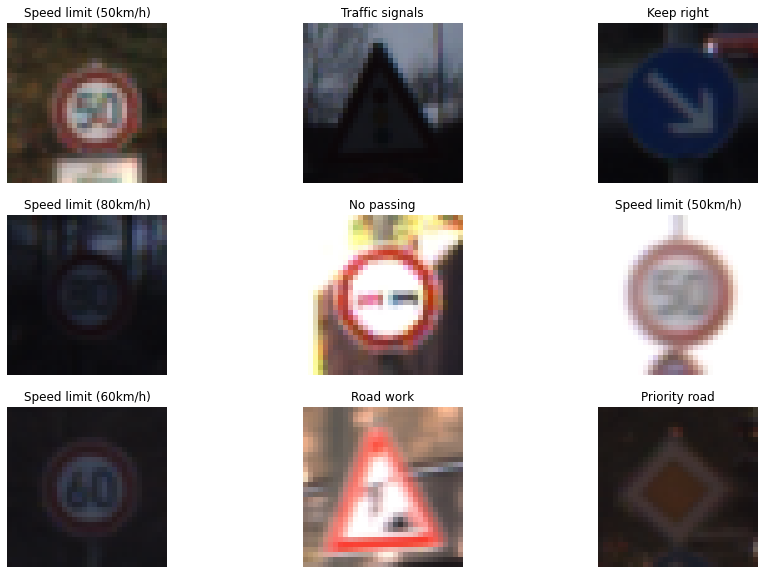

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

plt.figure(figsize=(15, 10))
for i in range(9):
    rand_idx = np.random.randint(0, n_train)
    
    # plot random image and its label
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[rand_idx])
    plt.title(signnames.iloc[y_train[rand_idx]]['SignName'])
    plt.axis("off")
    plt.savefig('./doc_images/examples.png')

View class distribution of the 3 data sets. Although there is some imbalance, the distribution seems similar across the 3 sets.

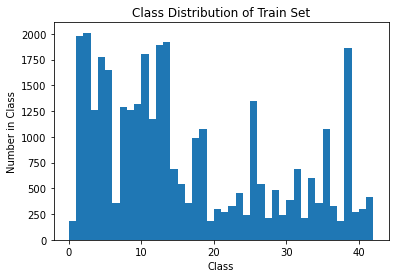

In [226]:
plt.hist(y_train, bins=n_classes-1)
plt.title('Class Distribution of Train Set')
plt.ylabel('Number in Class')
plt.xlabel('Class')
plt.savefig('./doc_images/class_distribution.png')
plt.show()

In [5]:
train_class_freq, _ = np.histogram(y_train, bins=n_classes-1)

print('Average frequency of each class: ', train_class_freq.mean())
print('Median frequency of each class: ', np.median(train_class_freq))

Average frequency of each class:  828.547619047619
Median frequency of each class:  540.0


In [6]:
# valid_class_freq, _ = np.histogram(y_valid, bins=n_classes-1)

# plt.hist(y_valid, bins=n_classes-1)
# plt.title('Class Distribution of Validation Set')
# plt.ylabel('Number in Class')
# plt.xlabel('Class')
# plt.show()

In [7]:
# test_class_freq, _ = np.histogram(y_test, bins=n_classes-1)

# plt.hist(y_test, bins=n_classes-1)
# plt.title('Class Distribution of Test Set')
# plt.ylabel('Number in Class')
# plt.xlabel('Class')
# plt.show()

## Pre-Processing

See `preprocessing()` method in model class for normalization and data augmentation (in TensorFlow)

### Data Augmentation and Upsampling

Not sure how to upsample specific classes in TF, so going to do so here w/ NumPy. Upsampling classes that have fewer examples in order to balance the classes a bit more. `tf.image` may also be a viable option.

In [8]:
from skimage.transform import warp, AffineTransform, rotate
from skimage.util import random_noise

def upsample_augment(X, y, class_freq):
    """
    This function upsamples underrepresented (freq < mean freq) classes by creating 
    augmented images of the original classes.
    
    Args:
        X (np.ndarray): input data
        y (np.ndarray): labels vector
        class_freq (List[int]): frequency of each class, where class label is idx of array
        
    Returns:
        returns upsampled X and y
    """
    num_tfm_types = 3  # translate, rotate, noise
    mean_freq = int(class_freq.mean())  # mean of class frequencies
    for class_label, freq in enumerate(class_freq):
        
        # to store augmented data, will be combined w/ existing data sets
        X_augmented = []
        y_augmented = []
        
        if freq < mean_freq:
            # this class is underrepresented, upsample via data augmentation
            num_to_add = mean_freq - freq
            num_for_each_tfm = num_to_add // num_tfm_types
            
            #print(class_label, freq, 'is <', mean_freq, 'adding', num_to_add, num_for_each_tfm, 'each')
            
            # get examples of this class from X
            class_examples = X[y == class_label]
            
            # add enough augmented images to get this class to the original mean
            idx = 0
            for _ in range(num_to_add):
                # get img to augment
                img = class_examples[idx]
                
                # warp/shift/translate
                if idx % num_tfm_types == 0:
                    #print('translate')
                    tfm = AffineTransform(translation=(np.random.randint(-5, 5), np.random.randint(-5, 5)))
                    augmented_img = np.uint8(255*warp(img, tfm, mode='wrap'))
            
                # rotate
                elif idx % num_tfm_types == 1:
                    #print('rotate')
                    augmented_img = np.uint8(255*rotate(img, angle=np.random.randint(-15, 15), mode='wrap'))

                # add noise
                elif idx % num_tfm_types == 2:
                    #print('noise')
                    augmented_img = np.uint8(255*random_noise(img, var=0.005))
                    
                    
                # store data
                X_augmented.append(augmented_img)
                y_augmented.append(class_label)
                
                # end of examples? wraparound and start again at 0
                if idx == (len(class_examples) - 1):
                    idx = 0
                else:
                    idx += 1
                      
            # add augmented data to existing data
            X = np.vstack((X, np.array(X_augmented)))
            y = np.hstack((y, np.array(y_augmented)))
                
    return X, y
    
# upsample for train/valid/test
X_train, y_train = upsample_augment(X_train, y_train, train_class_freq)

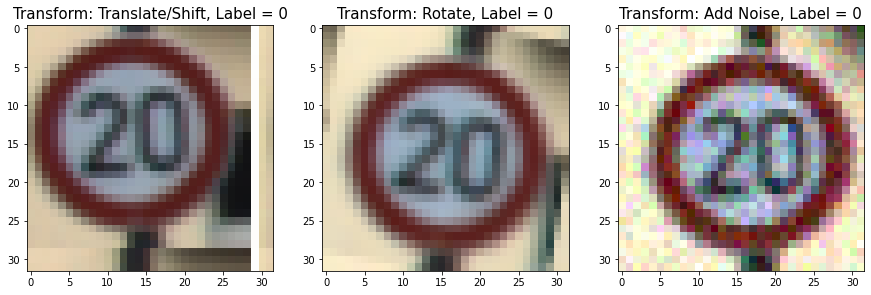

In [20]:
# plot example of data augmentation
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(X_train[n_train])
plt.title(f'Transform: Translate/Shift, Label = {y_train[n_train]}', fontsize=15)

plt.subplot(1, 3, 2)
plt.imshow(X_train[n_train+1])
plt.title(f'Transform: Rotate, Label = {y_train[n_train+1]}', fontsize=15)

plt.subplot(1, 3, 3)
plt.imshow(X_train[n_train+2])
plt.title(f'Transform: Add Noise, Label = {y_train[n_train+2]}', fontsize=15)
plt.savefig('./doc_images/augmentation.png')
plt.show()

In [22]:
# recalculate data set stats
n_train = len(X_train)
print("Number of training examples =", n_train)

Number of training examples = 46380


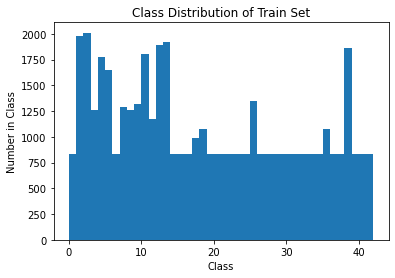

In [224]:
plt.hist(y_train, bins=n_classes-1)
plt.title('Class Distribution of Train Set')
plt.ylabel('Number in Class')
plt.xlabel('Class')
plt.savefig('./doc_images/class_distribution_after_balance.png')
plt.show()

Result of upsampling ^. Looks weird, could try downsampling high freq classes next

In [24]:
# look at class balance now
train_class_freq, _ = np.histogram(y_train, bins=n_classes-1)

print('Average frequency of each class: ', train_class_freq.mean())
print('Median frequency of each class: ', np.median(train_class_freq))

Average frequency of each class:  1104.2857142857142
Median frequency of each class:  828.0


## CNN Model Architecture

Using LeNet-5 as the default architecure and making changes from there: 
![Lenet-5](doc_images/lenet.png)

#### Low-level TensorFlow Implementation, similar to TF 1 (for reference): 

In [12]:
# def conv(x, W, b, strides):
#     """
#     Perform convolution with activation
    
#     Args:
#         x (np.ndarray): input to be convolved
#         W (tf.Variable): weights for the 'Xw' part of Xw + b
#         b (tf.Variable): biases for the 'b' part of Xw + b
#     """
#     conv = tf.nn.conv2d(x, W, [1, strides, strides, 1], padding="VALID")
#     conv = tf.nn.bias_add(conv, b)
#     return tf.nn.relu(conv)

# def max_pool(x, k, s):
#     """
#     Perform max pooling
    
#     Args:
#         x (np.ndarray): input to be pooled
#         k (int): kernel size, sometimes referred to as k or F
#         s (int): stride length
#     """
#     return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, s, s, 1], padding="VALID")

In [13]:
# random_normal = tf.initializers.RandomNormal()

# # 'c' conv, 'f' fully connected

# weights = {
#     # 32x32x3 => 28x28x6 with a 5x5 filter, stride=1
#     'wc1': tf.Variable(random_normal([5, 5, 3, 6])),
#     # 14x14x6 => 10x10x16 with 5x5 filter, stride=1
#     'wc2': tf.Variable(random_normal([5, 5, 6, 16])),
#     # 5x5x16 or 400 => 120
#     'wf1': tf.Variable(random_normal([400, 120])),
#     # 120 => 84
#     'wf2': tf.Variable(random_normal([120, 84])),
#     # 84 => 43 classes
#     'wf3': tf.Variable(random_normal([84, n_classes]))
# }

# biases = {
#     'bc1': tf.Variable(tf.zeros([6])),
#     'bc2': tf.Variable(tf.zeros([16])),
#     'bf1': tf.Variable(tf.zeros([120])),
#     'bf2': tf.Variable(tf.zeros([84])),
#     'bf3': tf.Variable(tf.zeros([n_classes]))
# }

In [14]:
# def low_net(x):
#     """Low-level TF 2 (similar to TF 1) implementation of LeNet"""
#     # for weight/bias initialization
#     mu = 0
#     sigma = 0.1
    
#     # first conv layer and pooling
#     conv1 = conv(x, weights['wc1'], biases['bc1'], strides=1)  # 28x28x6
#     pool1 = max_pool(conv1, k=2, s=2)  # 14x14x6
#     out1 = tf.nn.relu(pool1)
    
#     # second conv layer and pooling
#     conv2 = conv(out1, weights['wc2'], biases['bc2'], strides=1)  # 10x10x16
#     pool2 = max_pool(conv2, k=2, s=2)  # 5x5x16
#     out2 = tf.nn.relu(pool2)
    
#     # flatten from 5x5x16 to 400, weights['wf1'].get_shape().as_list()[0]]
#     flattened = tf.reshape(out2, 400)
    
#     # first fully connected layer
#     fc1 = tf.bias_add(tf.matmul(flattened, weights['wf1']), biases['bf1'])
#     fc1 = tf.nn.relu(fc1)
    
#     # second fully connected layer
#     fc2 = tf.bias_add(tf.matmul(fc1, weights['wf2']), biases['bf2'])
#     fc2 = tf.nn.relu(fc2)
    
#     # last fc layer (output)
#     logits = tf.bias_add(tf.matmul(fc2, weights['wf3']), biases['bf3'])
        
#     return logits

#### Using TF 2 `layers` and `model` API:

Quite similar to PyTorch API - contstruct a class inheriting from the `Model` module, define the architecture as a series of functions and implement the forward pass or computational graph by calling the functions in a `call(x)` or `forward(x)` method

In [25]:
from tensorflow.keras import Model, layers

In [35]:
class LeNet(Model):
    def __init__(self):
        """Define the architecture"""
        super(LeNet, self).__init__(name="GrantNet")
        
        # conv1: 32x32x3 => 28x28x32 with a 5x5 kernel, stride=1
        # NOTE: 'filters' arg is # of feature maps
        self.conv1 = layers.Conv2D(
            filters=32, kernel_size=5, strides=(1,1), 
            padding="valid", activation=tf.nn.relu
        )
        
        # max pooling: 28x28x32 => 14x14x32 with 2x2 kernel, stride=2; 
        #self.pool1 = layers.MaxPool2D(pool_size=2, strides=2, padding="valid")
        
        # conv2: 14x14x32 => 10x10x64 with a 5x5 kernel, stride=1
        # conv2 (w/o 1st layer pooling): 28x28x32 => 24x24x32
        self.conv2 = layers.Conv2D(
            filters=64, kernel_size=5, strides=(1,1), 
            padding="valid", activation=tf.nn.relu
        )
        
        # max pooling: 10x10x64 => 5x5x64 with 2x2 kernel, stride=2 
        # max pooling (w/o 1st layer pooling): 24x24x64 => 12x12x64
        self.pool2 = layers.MaxPool2D(pool_size=2, strides=2, padding="valid")
        
        # 5x5x64 => 1600 to be fed into fully connected layers
        # w/o 1st layer pooling: 12x12x64 => 9216
        self.flatten = layers.Flatten()
        
        # fully connected layer 1
        #self.fc1 = layers.Dense(1600, activation='relu')
        self.fc1 = layers.Dense(9216, activation='relu')  # w/o 1st layer pooling
        
        # dropout
        self.dropout1 = layers.Dropout(rate=0.5)
        
        # fc2
        self.fc2 = layers.Dense(800, activation='relu')
        
        # dropout
        self.dropout2 = layers.Dropout(rate=0.35)
        
        # fc3
        self.fc3 = layers.Dense(400, activation='relu')
        
        # dropout
        self.dropout3 = layers.Dropout(rate=0.25)
        
        # fc4
        self.fc4 = layers.Dense(120, activation='relu')
        
        # dropout
        self.dropout4 = layers.Dropout(rate=0.1)
        
        # output layer
        self.out = layers.Dense(n_classes)
        
        
    def augment(self, x, augment_factor=0.1):
        """
        NOTE: REPLACED this with numpy implementation in the Preprocessing section. This allowed me
        to upsample specific classes that were underrepresented by augmenting existing images
        in that class.
        
        This function adds data augmentation to the pipeline

        Args:
            x (tf tensor): input data
            augment_factor (float (0, 1)): how much to augment the data as a percentage
        """
        # random augmentation (contrast, rotation, translation, zoom)
        contrast_layer = layers.experimental.preprocessing.RandomContrast(augment_factor)
        rotation_layer = layers.experimental.preprocessing.RandomRotation(factor=augment_factor)
        translation_layer = layers.experimental.preprocessing.RandomTranslation(height_factor=augment_factor, width_factor=augment_factor)
        zoom_layer = layers.experimental.preprocessing.RandomZoom(height_factor=augment_factor, width_factor=augment_factor)
        
        # preprocess the data
        # data augmentation
        x = contrast_layer(x)
        x = rotation_layer(x)
        x = translation_layer(x)
        x = zoom_layer(x)       

        return x
    
    
    def normalize(self, x):
        """This function normalizes the input data from 0-255 to 0-1"""
        normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
        return normalization_layer(x)
        
        
    def call(self, x, is_training=False):
        """The forward pass"""
#         if is_training:
#             x = self.augment(x)
        x = self.normalize(x)
        x = tf.reshape(x, [-1, img_shape[0], img_shape[1], img_shape[2]])
        x = self.conv1(x)
        #x = self.pool1(x)  # w/o 1st layer pooling
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout1(x, training=is_training)  # only dropout in training
        x = self.fc2(x)
        x = self.dropout2(x, training=is_training)
        x = self.fc3(x)
        x = self.dropout3(x, training=is_training)
        x = self.fc4(x)
        x = self.dropout4(x, training=is_training)
        x = self.out(x)
        if not is_training:
            # only apply softmax when predicting
            # tf CE w/ logits function expects logits for training loss
            x = tf.nn.softmax(x)
        return x

In [36]:
# inst. the model
model = LeNet()

#### Keras / TF2 Implementation

In [37]:
# optional: much simpler but abstracts away some flexibility in the implementation

## Evaluation

In [38]:
def cross_entropy_loss(logits, y):
    """Compute cross entropy loss given logits and labels (y)"""
    y = tf.cast(y, tf.int64)
    
    # apply softmax to logits and compute cross entropy
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    
    # return avg loss across entire batch
    return tf.reduce_mean(loss)

def accuracy(pred_logits, y):
    """Compute accuracy given predictions and labels"""
    correct_preds = tf.equal(tf.argmax(pred_logits, 1), tf.cast(y, tf.int64)) # prediction is argmax of logits
    return tf.reduce_mean(tf.cast(correct_preds, tf.float32), axis=-1)

rate = 0.001
optimizer = tf.optimizers.Adam(rate)

## Training

In [39]:
def run_optimization(X, y):
    """Run TF 2 optimization, including forward pass, loss calculation, and backward pass"""
    with tf.GradientTape() as g:
        logits = model(X, is_training=True)
        loss = cross_entropy_loss(logits, y)
        train_accuracy = accuracy(logits, y)
        
    parameters = model.trainable_variables
    gradients = g.gradient(loss, parameters)
    optimizer.apply_gradients(zip(gradients, parameters))  # use gradients to update parameters
    
    return train_accuracy

In [40]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [41]:
# some parameters
BATCH_SIZE = 128
EPOCHS = 30
MODEL_NAME = 'upsample'

In [42]:
from sklearn.utils import shuffle

num_examples = len(X_train)

train_accuracy_list = []
valid_accuracy_list = []

# training loop
for epoch in range(EPOCHS):
    X_train, y_train = shuffle(X_train, y_train)
    accumulated_accuracy = 0  # running total to compute avg
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_train[offset:offset+BATCH_SIZE], y_train[offset:offset+BATCH_SIZE]

        # optimize and get training accuracy
        batch_accuracy = run_optimization(batch_x, batch_y)
        accumulated_accuracy += batch_accuracy
        
    # average accuracy across batches (accum. acc divided by number of batches)
    train_accuracy = (accumulated_accuracy / (num_examples / BATCH_SIZE))
    train_accuracy_list.append(train_accuracy)
    
    # validate
    valid_preds = model(X_valid, is_training=False)  # returns preds as logits
    valid_accuracy = accuracy(valid_preds, y_valid)
    valid_accuracy_list.append(valid_accuracy)
    
    if epoch % 2 == 0:
        # print results every other epoch
        print(f'EPOCH {epoch+1}')
        print(f'Train Accuracy = {train_accuracy:.2%}')
        print(f'Valid Accuracy = {valid_accuracy:.2%}\n')

EPOCH 1
Train Accuracy = 62.06%
Valid Accuracy = 90.82%

EPOCH 3
Train Accuracy = 95.62%
Valid Accuracy = 96.24%

EPOCH 5
Train Accuracy = 97.95%
Valid Accuracy = 96.15%

EPOCH 7
Train Accuracy = 98.60%
Valid Accuracy = 95.74%

EPOCH 9
Train Accuracy = 98.85%
Valid Accuracy = 96.19%

EPOCH 11
Train Accuracy = 99.28%
Valid Accuracy = 96.69%

EPOCH 13
Train Accuracy = 99.21%
Valid Accuracy = 97.01%

EPOCH 15
Train Accuracy = 99.35%
Valid Accuracy = 96.46%

EPOCH 17
Train Accuracy = 99.40%
Valid Accuracy = 97.01%

EPOCH 19
Train Accuracy = 99.63%
Valid Accuracy = 97.32%

EPOCH 21
Train Accuracy = 99.32%
Valid Accuracy = 97.39%

EPOCH 23
Train Accuracy = 99.66%
Valid Accuracy = 97.28%

EPOCH 25
Train Accuracy = 99.66%
Valid Accuracy = 96.94%

EPOCH 27
Train Accuracy = 99.79%
Valid Accuracy = 96.55%

EPOCH 29
Train Accuracy = 99.61%
Valid Accuracy = 96.62%



**Why is validation accuracy typically higher than traning accuracy early on?** My guess is because the validation set is tested at the end of an epoch, so the model has an entire epoch to improve. As its making mistakes during that epoch, those mistakes are reflected in the training accuracy, while the validation accuracy is tested at the end of the epoch, likely taking advantage of the best model

In [43]:
print(model.summary())

Model: "GrantNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            multiple                  2432      
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_5 (Dense)              multiple                  84943872  
_________________________________________________________________
dropout_4 (Dropout)          multiple                  0         
_________________________________________________________________
dense_6 (Dense)              multiple                  737

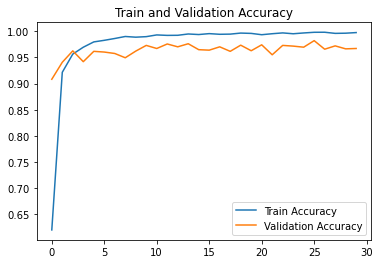

In [44]:
plt.plot(range(EPOCHS), train_accuracy_list, label='Train Accuracy')
plt.plot(range(EPOCHS), valid_accuracy_list, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Train and Validation Accuracy')
plt.savefig('./doc_images/accuracy.png')
plt.show()

In [45]:
MODEL_NAME = '30_epochs'

In [46]:
# save model
#!mkdir -p saved_model
model.save('saved_model/' + MODEL_NAME)

INFO:tensorflow:Assets written to: saved_model/30_epochs/assets


### Tracking Validation Performance w/ each add-on/change:
- Validation Accuracy = 91%, `EPOCHS` = 20, original LeNet architecture
- Validation Accuracy = 95%, `EPOCHS` = 20, original LeNet architecture, **added 50/30/10 dropout in FC layers**
- Validation Accuracy = 96%, `EPOCHS` = 25, **new architecture (3=>32=>64 feature maps, 1600=>800=>400=>120=>n_classes FC layers) , 50/35/25/10 dropout in FC layers**
- Validation Accuracy = 96%, `EPOCHS` = 25, **added data augmentation (contrast, rotate, translate, zoom) w/ `augment_factor=0.1`**
- Validation Accuracy = 96%, `EPOCHS` = 25, **removed pooling after 1st layer in case we're loosing too much info - note this reduces the downsampling and makes training more expensive**
- Validation Accuracy = 97%, `EPOCHS` = 30, **upsampled underrepresented classes with data augmentation**

#### View Performance on Specific Images from Validation Set

In [ ]:
# load model if necessary
# model_name = ''
# model = tf.keras.models.load_model('saved_model/' + model_name)

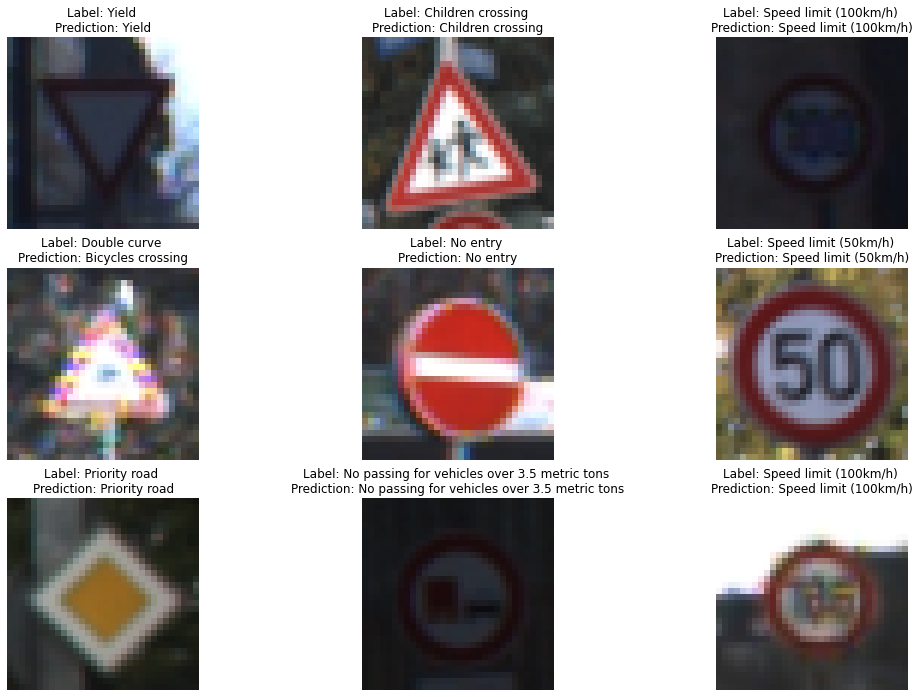

In [183]:
plt.figure(figsize=(18, 12))
for i in range(9):
    rand_idx = np.random.randint(0, n_valid)
    
    # get prediction
    pred = model(X_valid[rand_idx], is_training=False)
    
    # plot random image and its label
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_valid[rand_idx])
    plt.title(f'Label: {signnames.iloc[y_valid[rand_idx]]["SignName"]} \nPrediction: {signnames.iloc[pred.numpy().argmax()]["SignName"]}')
    plt.axis("off")
    plt.savefig('./doc_images/validation.png')

### Error Analysis
Inspecting the errors the network is making on the validation set

In [48]:
valid_preds = tf.argmax(valid_preds, 1).numpy()
y_valid = tf.cast(y_valid, tf.int64).numpy()

In [49]:
incorrect_preds = valid_preds[valid_preds != y_valid]
labels_of_incorrect_preds = y_valid[valid_preds != y_valid]

Look at distribution of the true **labels of incorrect predictions**:

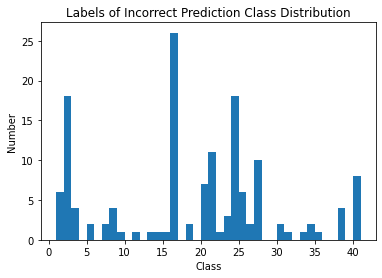

In [57]:
plt.hist(labels_of_incorrect_preds, bins=n_classes-3)
plt.title('Labels of Incorrect Prediction Class Distribution')
plt.ylabel('Number')
plt.xlabel('Class')
plt.show()

Get histogram of **labels of incorrect predictions:** 

In [72]:
# init
hist = {}
for i in range(n_classes):
    hist[i] = 0
    
# count
for label in labels_of_incorrect_preds:
    hist[label] += 1

In [94]:
sorted_keys = sorted(hist, key=hist.get, reverse=True)

# get k most common incorrect predictions
k = 5
print('Most common labels of incorrect predictions:\n')
for label in sorted_keys[:k]:
    print(f'[{signnames.iloc[label]["SignName"]}] was missed {hist[label]} times')

Most common labels of incorrect predictions:

[Vehicles over 3.5 metric tons prohibited] was missed 26 times
[Speed limit (50km/h)] was missed 18 times
[Road narrows on the right] was missed 18 times
[Double curve] was missed 11 times
[Pedestrians] was missed 10 times


Look at distribution of **incorrect predictions**, i.e. the model guessed this class but was incorrect

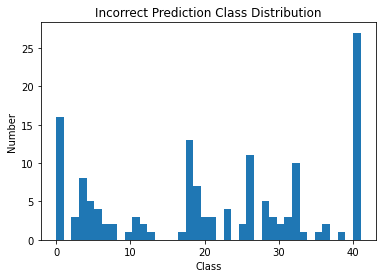

In [95]:
plt.hist(incorrect_preds, bins=n_classes-3)
plt.title('Incorrect Prediction Class Distribution')
plt.ylabel('Number')
plt.xlabel('Class')
plt.show()

In [97]:
# init
pred_hist = {}
for i in range(n_classes):
    pred_hist[i] = 0
    
# count
for pred in incorrect_preds:
    pred_hist[pred] += 1

In [98]:
sorted_keys_pred = sorted(pred_hist, key=pred_hist.get, reverse=True)

# get k most common incorrect predictions
k = 5
print('Most common labels of incorrect predictions:\n')
for pred in sorted_keys_pred[:k]:
    print(f'[{signnames.iloc[pred]["SignName"]}] was incorrectly predicted {pred_hist[pred]} times')

Most common labels of incorrect predictions:

[End of no passing] was incorrectly predicted 26 times
[Speed limit (30km/h)] was incorrectly predicted 15 times
[General caution] was incorrectly predicted 13 times
[Traffic signals] was incorrectly predicted 11 times
[End of all speed and passing limits] was incorrectly predicted 10 times


To get a better idea of the mistakes, let's look at this most common misclassification pairs: `(pred, label)`

In [106]:
# count the frequencies of each pair
pair_map = {}
for pair in zip(incorrect_preds, labels_of_incorrect_preds):
    pair_map[pair] = pair_map.get(pair, 0) + 1
    
# sort based on number of times this pair showed up
pair_map_sorted = sorted(pair_map, key=pair_map.get, reverse=True)

k = 5
k_count = 0
print('Most common misclassifications: \n')
for pair in pair_map_sorted[:k]:
    k_count += pair_map[pair]
    print(f'Prediction = [{signnames.iloc[pair[0]]["SignName"]}], Label = [{signnames.iloc[pair[1]]["SignName"]}] happened {pair_map[pair]} times')

Most common misclassifications: 

Prediction = [End of no passing], Label = [Vehicles over 3.5 metric tons prohibited] happened 26 times
Prediction = [Speed limit (30km/h)], Label = [Speed limit (50km/h)] happened 12 times
Prediction = [Traffic signals], Label = [Road narrows on the right] happened 11 times
Prediction = [General caution], Label = [Pedestrians] happened 10 times
Prediction = [Speed limit (70km/h)], Label = [Speed limit (30km/h)] happened 5 times


In [107]:
# nearly half the mistakes are these 5 pairs, good to know
k_count / len(incorrect_preds)

0.4383561643835616

**Error Analysis Conclusion:** Most misclassified example is **Prediction = [End of no passing], Label = [Vehicles over 3.5 metric tons prohibited]** which happened 26 times, well over 2X as much as the next most common misclassification. The other mistakes are discussed in the below bullet points. BUT, its reassuring to see that its the same few mistakes for the majority of mistakes (~50% of the mistakes are the same 5 pairs of incorrect predictions and labels). 2 of the other most common misclassifications are related to speed limit signs, mistaking 3s for 5s and 7s for 3s. 

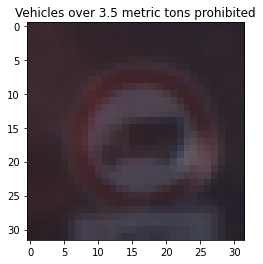

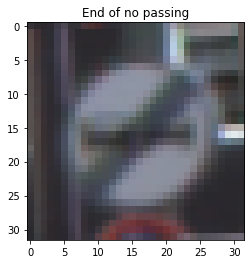

In [136]:
# this error is a bit surprising since the signs don't seem that similar
plt.imshow(X_train[y_train == pair_map_sorted[0][1]][5])
plt.title(signnames.iloc[pair_map_sorted[0][1]]["SignName"])
plt.show()

plt.imshow(X_train[y_train == pair_map_sorted[0][0]][4])
plt.title(signnames.iloc[pair_map_sorted[0][0]]["SignName"])
plt.show()


## Test Accuracy = 96%

In [137]:
# not enough memory to test entire set at once, likely due to removing pooling
test_preds = model(X_test[:len(X_test) // 2], is_training=False)  # returns preds as logits
half_one = accuracy(test_preds, y_test[:len(X_test) // 2])

test_preds = model(X_test[len(X_test) // 2:], is_training=False)
half_two =  accuracy(test_preds, y_test[len(X_test) // 2:])

print(f'Test Accuracy = {(half_one + half_two) / 2}')

Test Accuracy = 0.9570071697235107


#### Test Images Taken From Internet


Softmax probabilities for topk predictions:
 tf.Tensor([[1.000000e+00 5.147834e-31 0.000000e+00 0.000000e+00 0.000000e+00]], shape=(1, 5), dtype=float32)

Softmax probabilities for topk predictions:
 tf.Tensor([[1.0000000e+00 1.4782298e-13 2.4975122e-14 1.6696974e-14 1.0012563e-14]], shape=(1, 5), dtype=float32)

Softmax probabilities for topk predictions:
 tf.Tensor([[1.0000000e+00 7.6310989e-12 1.9515762e-13 3.2194525e-17 8.6979903e-18]], shape=(1, 5), dtype=float32)

Softmax probabilities for topk predictions:
 tf.Tensor([[1. 0. 0. 0. 0.]], shape=(1, 5), dtype=float32)

Softmax probabilities for topk predictions:
 tf.Tensor([[9.5701665e-01 4.2583689e-02 3.7677525e-04 1.6078013e-05 3.3640463e-06]], shape=(1, 5), dtype=float32)


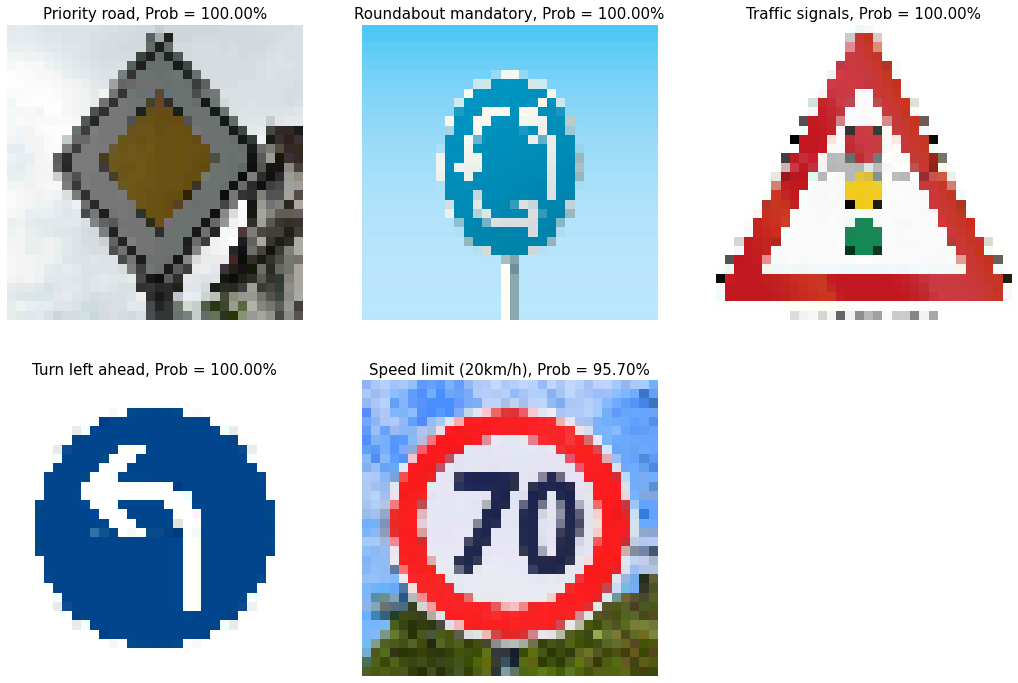

In [215]:
import glob
import cv2

plt.figure(figsize=(18, 12))
for idx, file in enumerate(glob.glob('./new_traffic_signs/*.jpg')):
    # read, convert to rgb, resize to 32x32x3
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_shape[:2])
    
    # predict
    pred = model(img)
    k = 5
    values, indices = tf.math.top_k(pred, k)
    print('\nSoftmax probabilities for topk predictions:\n', values)
    pred = tf.argmax(pred, 1).numpy()[0]
        
    # plot
    ax = plt.subplot(2, 3, idx + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f'{signnames.iloc[pred].SignName}, Prob = {values[0][0]:.2%}', fontsize=15)
    plt.savefig('./doc_images/web_predictions.png')

The model seems to be overconfident, suggesting class separation is not as robust as one would hope. In addition to being nearly 100% confident about the first 4 correctly classified examples above, the model says the 70km/h sign has a 95.7% probability of being a 20km/h sign.

Fortunately, the class with the 2nd highest probability (4.2%) was 70km/h, which is of course the correct answer. See below: 

In [222]:
values[0][1]

<tf.Tensor: shape=(), dtype=float32, numpy=0.04258369>

In [223]:
signnames.iloc[indices[0][1].numpy()]["SignName"]

'Speed limit (70km/h)'

## Vizualize layers, time permitting